In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from cvx_portfolio.costs import TcostModel
from cvx_portfolio.simulator import MarketSimulator
from cvx_portfolio.policies import Hold,PeriodicRebalance

plotdir = '../portfolio/plots/'
datadir= '../equity_data_tool/'

## Download data using ee103 code (to be integrated) 

In [2]:
sigmas=pd.read_csv(datadir+'sigmas.txt',index_col=0,parse_dates=[0])
returns=pd.read_csv(datadir+'returns.txt',index_col=0,parse_dates=[0])
volumes=pd.read_csv(datadir+'volumes.txt',index_col=0,parse_dates=[0])
prices=pd.read_csv(datadir+'prices.txt',index_col=0,parse_dates=[0])

## Market simulator 

In [3]:
spread = pd.DataFrame(data=2.5*1e-4, index=volumes.index, columns=volumes.columns)
nonlin_coeff = pd.DataFrame(data=1, index=volumes.index, columns=volumes.columns) # fix volatility model

simulated_tcost = TcostModel(volumes, sigmas, spread, nonlin_coeff, cash_key='USDOLLAR')
simulator = MarketSimulator(returns, volumes, [simulated_tcost], cash_key='USDOLLAR')

## Portfolio

In [4]:
benchmark = pd.Series(index=returns.columns, data=1)/len(returns.columns)
benchmark/=sum(benchmark)

## Policy

In [5]:
def select_starts_periods(period_property, timestamps):
    selected = [timestamps[0]]
    last_day = timestamps[0]
    for day in timestamps[1:]:
        if not (period_property(day) == period_property(last_day)):
            selected.append(day)
            last_day=day
    return selected

In [6]:
selectors=pd.Series(index=['D','W','M','Q','A'],
                    data=[lambda t: t.day,lambda t: t.week,lambda t: t.month,lambda t: t.quarter,lambda t: t.year])
rebalancing_times = selectors.apply(lambda x: select_starts_periods(x, returns.index) )
policies = rebalancing_times.apply(lambda x: PeriodicRebalance(target=benchmark, rebalancing_times=x))
policies['H'] = Hold()

## Simulations

In [7]:
res_small_fund=pd.Series(index=policies.index, 
                         data=simulator.run_multiple_backtest(1E8*benchmark, 
                                                              start_time="2012-01-01", 
                                                              end_time="2016-12-31",
                                                              policies=policies.values))
res_large_fund=pd.Series(index=policies.index, 
                         data=simulator.run_multiple_backtest(1E10*benchmark, 
                                                              start_time="2012-01-01", 
                                                              end_time="2016-12-31",
                                                              policies=policies.values))

res=pd.DataFrame({'\$100M':res_small_fund, '\$10B': res_large_fund})

## Results 

In [56]:
avg_daily_return=lambda res: 10000*(res.mean_return)/250
total_tcost=lambda res: (res.simulator_TcostModel.sum(1)).sum() / 1E6
avg_daily_tcost=lambda res: (res.simulator_TcostModel.sum(1)/res.v).mean() * 10000
RMSE = lambda res: np.sqrt(np.mean((returns.loc[returns.index>'2012-01-01'].mean(1) - res.returns)**2))*10000
final_val = lambda res: res.v[-1]/1E9

table=pd.DataFrame({'Daily return (b.p.)':res.applymap(avg_daily_return).unstack(),
               'Return RMSE (b.p.)':res.applymap(RMSE).unstack(),
              'Total trans. costs ($M)':res.applymap(total_tcost).unstack(), 
              "Daily tcost (b.p.)":res.applymap(avg_daily_tcost).unstack(),
             })
print(table.to_latex(float_format='%.2f'))

\begin{tabular}{llrrrr}
\toprule
       &   &  Daily return (b.p.) &  Daily tcost (b.p.) &  Return RMSE (b.p.) &  Total trans. costs (\$M) \\
\midrule
\textbackslash\$100M & D &                 6.71 &                0.03 &                0.04 &                     0.70 \\
       & W &                 6.73 &                0.02 &                0.55 &                     0.39 \\
       & M &                 6.74 &                0.01 &                1.26 &                     0.24 \\
       & Q &                 6.77 &                0.01 &                2.20 &                     0.16 \\
       & A &                 6.77 &                0.00 &                4.57 &                     0.09 \\
       & H &                 6.79 &                0.00 &               12.81 &                     0.00 \\
\textbackslash\$10B & D &                 6.60 &                0.15 &                0.17 &                   306.42 \\
       & W &                 6.66 &                0.10 &         

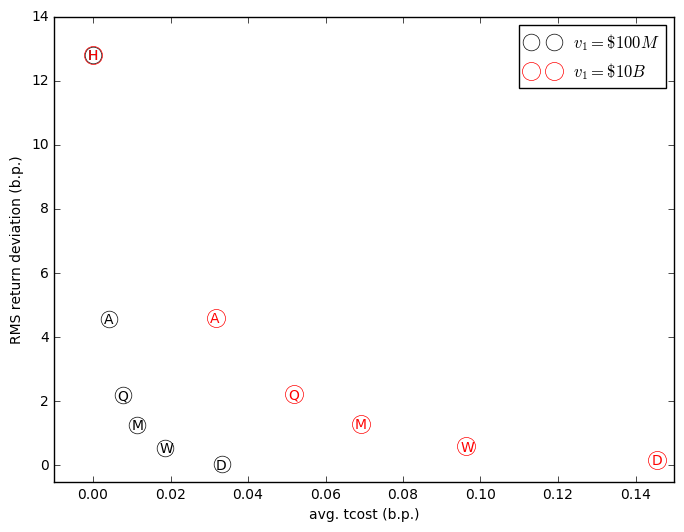

In [65]:
offsetx = 0.0015
offsety = 0.15
plt.figure(figsize=(8,6))
colors=['k','r']
lines=[None,None]
for en,j in enumerate(res.columns):
    for i in res.index:
        y = RMSE(res.loc[(i, j)])
        x = avg_daily_tcost(res.loc[(i, j)])
        line,=plt.plot(np.array(x),np.array(y), colors[en]+'o', markersize=12+en,
                  fillstyle='none', label='$v_1 = %s$'%j)
        lines[en] = line
        plt.text(x-offsetx,y-offsety, i,color=colors[en] )


plt.legend(loc='upper right',handles=lines)
plt.xlabel(r'avg. tcost (b.p.)')
plt.ylabel('RMS return deviation (b.p.)')
#plt.title("Rebalancing strategies for uniform portfolio (2012-2016)")
plt.xlim([-0.01,0.15])
plt.ylim([- 0.5, 14])
plt.savefig(plotdir+'basic_frontier.png')

In [13]:
# offsetx = 0.05
# offsety = 0.06

# for ticker, values in result_df.iterrows():
#     for size, coord in values.unstack().iterrows():
#         x,y=coord['TCosts'],coord['Profit']
#         if size=='$100M':
#             line1,=plt.plot(x,y, 'ko', markersize=12, fillstyle='none', label='\$100M fund')
#             plt.text(x-offsetx,y-offsety, ticker)

#         if size=='$10B':
#             line2,=plt.plot(x,y, 'ro', markersize=13, fillstyle='none', label='\$10B fund')
#             plt.text(x-offsetx,y-offsety,ticker,color='r' )

# #plt.xlim([-.5, 4])
# #plt.ylim([117,123.5])
# plt.legend(loc='upper right',handles=[line1, line2])
# plt.xlabel("Simulated t. costs (%)")
# plt.ylabel("Simulated profit (%)")
# plt.title("Rebalancing strategies for uniform portfolio (2012-2016)")

# plt.savefig(plotdir+'pandl_vs_tcost.png')

# Plots 

In [84]:
# offsetx = 0.05
# offsety = 0.06

# for ticker, values in result_df.iterrows():
#     for size, coord in values.unstack().iterrows():
#         x,y=coord['TCosts'],coord['Profit']
#         if size=='$100M':
#             line1,=plt.plot(x,y, 'ko', markersize=12, fillstyle='none', label='\$100M fund')
#             plt.text(x-offsetx,y-offsety, ticker)

#         if size=='$10B':
#             line2,=plt.plot(x,y, 'ro', markersize=13, fillstyle='none', label='\$10B fund')
#             plt.text(x-offsetx,y-offsety,ticker,color='r' )

# plt.xlim([-.5, 4])
# plt.ylim([117,123.5])
# plt.legend(loc='upper right',handles=[line1, line2])
# plt.xlabel("Simulated t. costs (%)")
# plt.ylabel("Simulated profit (%)")
# plt.title("Rebalancing strategies for uniform portfolio (2012-2016)")

# plt.savefig(plotdir+'return_vs_volatility.png')

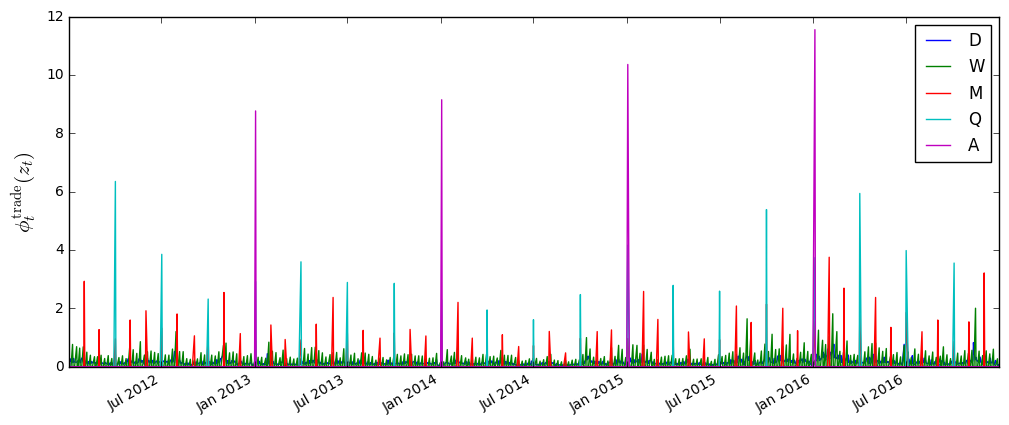

In [117]:
res.loc[:, '\$10B'].apply(lambda x: 10000*x.simulator_TcostModel.sum(1)/x.v).T.ix[:,:-1].plot(figsize=(12,5))
plt.ylabel("$\phi_t^{\mathrm{trade}}(z_t)$",fontsize=15)
plt.savefig(plotdir+'basic_example_tcost_time.png')

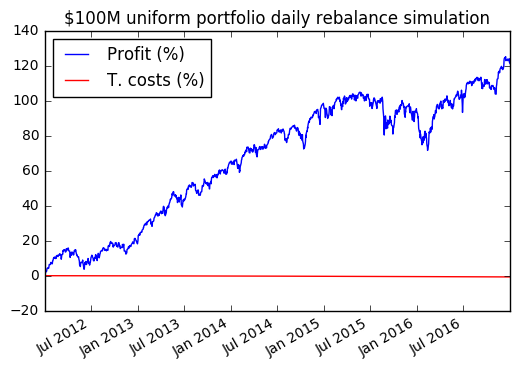

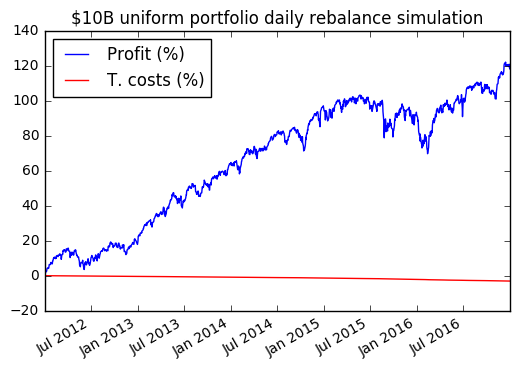

In [66]:
for k,results in res.loc['D'].iteritems():
    plt.figure()
    (100*(results.v-results.initial_val)/results.initial_val).plot(label='Profit (%)')
    (100*(-results.simulator_TcostModel.sum(1).cumsum())/results.initial_val).plot(style='r',label='T. costs (%)')
    plt.legend(loc='upper left')
    plt.title('%s uniform portfolio daily rebalance simulation'%k)
    plt.savefig(plotdir+'%s_pandl_tcost_tseries.png'%k[1:])